# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.2 MB/s eta 0:00:00


In [ ]:
!mkdir /content/dataset/
!mkdir -p /content/dataset/train2C/
!mkdir -p /content/dataset/val2C/
!tar -xvzf /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train.tgz -C /content/dataset/train2C/
!tar -xvzf /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/val.tgz -C /content/dataset/val2C/
!mkdir -p /content/dataset/test2C/
!tar -xvzf /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/test/test2C.tgz -C /content/dataset/test2C/

Streaming output truncated to the last 5000 lines.
testX/xxx04139.jpg
testX/xxx05763.jpg
testX/xxx01199.jpg
testX/xxx03592.jpg
testX/xxx06086.jpg
testX/xxx02062.jpg
testX/xxx01124.jpg
testX/xxx00143.jpg
testX/xxx05437.jpg
testX/xxx00356.jpg
testX/xxx03594.jpg
testX/xxx02648.jpg
testX/xxx02681.jpg
testX/xxx01684.jpg
testX/xxx02143.jpg
testX/xxx01114.jpg
testX/xxx01592.jpg
testX/xxx02163.jpg
testX/xxx05441.jpg
testX/xxx02756.jpg
testX/xxx01785.jpg
testX/xxx00855.jpg
testX/xxx05754.jpg
testX/xxx00763.jpg
testX/xxx01156.jpg
testX/xxx03947.jpg
testX/xxx04798.jpg
testX/xxx05700.jpg
testX/xxx01011.jpg
testX/xxx05481.jpg
testX/xxx03439.jpg
testX/xxx02784.jpg
testX/xxx04103.jpg
testX/xxx04951.jpg
testX/xxx00865.jpg
testX/xxx05506.jpg
testX/xxx02922.jpg
testX/xxx02887.jpg
testX/xxx05907.jpg
testX/xxx02986.jpg
testX/xxx01465.jpg
testX/xxx03753.jpg
testX/xxx04834.jpg
testX/xxx03365.jpg
testX/xxx01115.jpg
testX/xxx02641.jpg
testX/xxx01640.jpg
testX/xxx00853.jpg
testX/xxx01432.jpg
testX/xxx05449.jpg

# Initialization

In [ ]:
%cd /content/drive/MyDrive/MaiaSpain/CAD/project/

/content/drive/MyDrive/MaiaSpain/CAD/project


In [ ]:
import os
import numpy as np
from torch.utils.data import WeightedRandomSampler
from monai.transforms import (
    Compose, Rand2DElasticd, RandRotate90d, RandFlipd, RandAffined, ScaleIntensityd,
    RandCoarseShuffled, EnsureTyped, LoadImaged, Resized, ToTensord, NormalizeIntensityd
)
from monai.data import PersistentDataset, Dataset, DataLoader
from monai.losses import FocalLoss
from PIL import Image
import torch
from torch import nn, tensor
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
from tqdm import tqdm
from torchvision import models
from shutil import rmtree
from transformers import DeiTForImageClassification, DeiTConfig
import csv

# Dataloader

In [ ]:
cls_to_idx = {'nevus':0,'others':1}
idx_to_cls = {0:'nevus',1:'others'}

def get_weights(data_path):
  classes = os.listdir(data_path)
  num_samples = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in classes}
  weights = {cls: (1 / num_samples[cls]) / sum((1 / v for v in num_samples.values())) for cls in classes}
  return weights

def get_data(data_path, cls_weights):
  data = []
  sample_weights = []
  classes = os.listdir(data_path)
  for cls in classes:
      cls_path = os.path.join(data_path, cls)
      for image_name in os.listdir(cls_path):
          image_path = os.path.join(cls_path, image_name)
          data.append({'image':image_path, 'label':cls_to_idx[cls]})
          sample_weights.append(cls_weights[cls])
  return data, sample_weights

In [ ]:
base_transforms = [
    LoadImaged('image',ensure_channel_first=True),
    Resized('image',(224, 224)),
    NormalizeIntensityd('image')
]

augmentations = [
    ScaleIntensityd('image',0,1),
    Rand2DElasticd('image',prob=0.5, spacing=56, magnitude_range=(1, 3), padding_mode="zeros"),
    RandRotate90d('image',prob=0.5, spatial_axes=[0, 1]),
    RandFlipd('image',prob=0.5, spatial_axis=0),
    RandFlipd('image',prob=0.5, spatial_axis=1),
    RandAffined('image',prob=0.5,rotate_range=(0.5, 0.5),padding_mode="zeros",),
    NormalizeIntensityd('image')
]

train_transform = Compose(base_transforms + augmentations)
val_transform = Compose(base_transforms)

# rmtree('/content/cache/',True)

cls_weights = get_weights("/content/dataset/train2C/train")
train_data, train_weights = get_data("/content/dataset/train2C/train", cls_weights)
val_data, val_weights = get_data("/content/dataset/val2C/val", cls_weights)

train_dataset = PersistentDataset(data=train_data, transform=train_transform, cache_dir='/content/cache/train')
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=os.cpu_count(), pin_memory=True)
val_dataset = PersistentDataset(data=val_data, transform=val_transform, cache_dir='/content/cache/val')
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

# Visualization

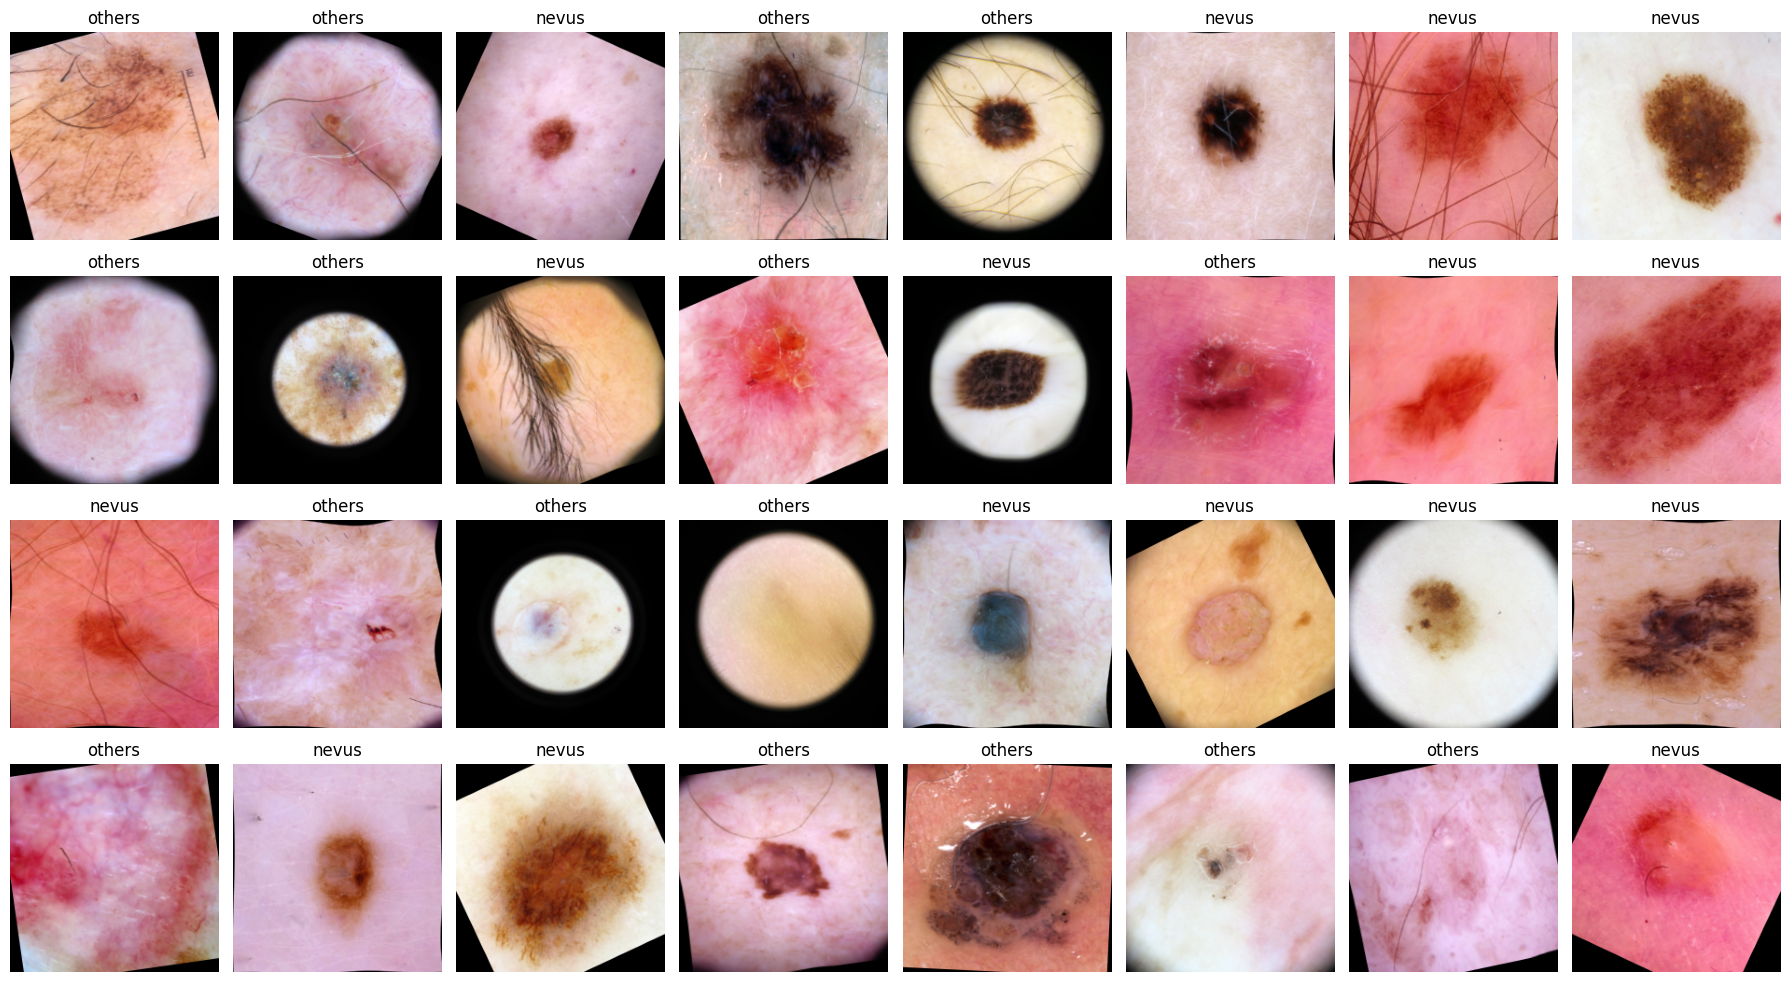

In [ ]:
# import matplotlib.pyplot as plt

# train_loader.dataset.transform.transforms = train_loader.dataset.transform.transforms+(ScaleIntensityd('image',0,1),)
# plt.figure(figsize=(18,10))
# batch = next(iter(train_loader))
# for i in range(32):
#   image, label = batch['image'][i], batch['label'][i]
#   plt.subplot(4,8,i+1)
#   plt.imshow(image.permute(1,2,0).numpy())
#   plt.title(idx_to_cls[label.item()])
#   plt.axis('off')
# plt.tight_layout()
# plt.show()

# Training and Evaluation

In [ ]:
def calculate_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    f1 = f1_score(labels, preds, average="macro")
    kappa = cohen_kappa_score(labels, preds)
    return accuracy, precision, recall, f1, kappa

def train_and_evaluate_model(model, train_loader, val_loader, device, epochs=30, min_delta=0.0001):
    model = model.to(device)
    criterion = FocalLoss(to_onehot_y=True, use_softmax=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler=StepLR(optimizer, step_size=15, gamma=0.2)
    best_accuracy = 0
    save_dir = "models_alberb_2cls/"
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs, embedding = outputs.logits, outputs.hidden_states[-1][:, -1, :]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss / len(train_loader):.4f}")

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                outputs = model(images)
                outputs = outputs.logits
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy, precision, recall, f1, kappa = calculate_metrics(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        print(f"Validation Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Kappa: {kappa:.4f}")
        print(f"Confusion Matrix:\n{cm}")

        if accuracy > best_accuracy + min_delta:
            model_path = os.path.join(save_dir, f"best_model_{accuracy:.4f}.pth")
            torch.save(model.state_dict(), model_path)
            if os.path.exists(os.path.join(save_dir, f"best_model_{best_accuracy:.4f}.pth")):
              os.remove(os.path.join(save_dir, f"best_model_{best_accuracy:.4f}.pth"))
            best_accuracy = accuracy
            print(f"Model saved to {model_path}")

# Experiments

In [ ]:
from transformers import DeiTForImageClassification, DeiTConfig

config = DeiTConfig.from_pretrained("facebook/deit-base-distilled-patch16-224")
config.num_labels, config.output_hidden_states = 2, True
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", config=config)
model.load_state_dict(torch.load('models_alberb_2cls/best_model_0.9131.pth'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-dc89655ca64e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

<All keys matched successfully>

In [ ]:
train_and_evaluate_model(
    model, train_loader, val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), epochs=100
)

Epoch 1/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 1/100, Training Loss: 0.0509


Validation Metrics - Accuracy: 0.8309, Precision: 0.8518, Recall: 0.8287, F1: 0.8276, Kappa: 0.6602
Confusion Matrix:
[[1837   94]
 [ 548 1317]]
Model saved to models_alberb_2cls/best_model_0.8309.pth


Epoch 2/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 2/100, Training Loss: 0.0419



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8643, Precision: 0.8683, Recall: 0.8634, F1: 0.8637, Kappa: 0.7281
Confusion Matrix:
[[1767  164]
 [ 351 1514]]
Model saved to models_alberb_2cls/best_model_0.8643.pth


Epoch 3/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 3/100, Training Loss: 0.0373



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8575, Precision: 0.8574, Recall: 0.8575, F1: 0.8574, Kappa: 0.7149
Confusion Matrix:
[[1659  272]
 [ 269 1596]]


Epoch 4/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 4/100, Training Loss: 0.0335



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8751, Precision: 0.8782, Recall: 0.8744, F1: 0.8747, Kappa: 0.7498
Confusion Matrix:
[[1774  157]
 [ 317 1548]]
Model saved to models_alberb_2cls/best_model_0.8751.pth


Epoch 5/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 5/100, Training Loss: 0.0315



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8501, Precision: 0.8506, Recall: 0.8504, F1: 0.8501, Kappa: 0.7004
Confusion Matrix:
[[1604  327]
 [ 242 1623]]


Epoch 6/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 6/100, Training Loss: 0.0294



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8778, Precision: 0.8799, Recall: 0.8771, F1: 0.8774, Kappa: 0.7552
Confusion Matrix:
[[1766  165]
 [ 299 1566]]
Model saved to models_alberb_2cls/best_model_0.8778.pth


Epoch 7/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 7/100, Training Loss: 0.0259



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8825, Precision: 0.8846, Recall: 0.8819, F1: 0.8822, Kappa: 0.7647
Confusion Matrix:
[[1773  158]
 [ 288 1577]]
Model saved to models_alberb_2cls/best_model_0.8825.pth


Epoch 8/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 8/100, Training Loss: 0.0231



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8772, Precision: 0.8781, Recall: 0.8777, F1: 0.8772, Kappa: 0.7546
Confusion Matrix:
[[1645  286]
 [ 180 1685]]


Epoch 9/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 9/100, Training Loss: 0.0208



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8878, Precision: 0.8881, Recall: 0.8881, F1: 0.8878, Kappa: 0.7756
Confusion Matrix:
[[1683  248]
 [ 178 1687]]
Model saved to models_alberb_2cls/best_model_0.8878.pth


Epoch 10/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 10/100, Training Loss: 0.0185



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8846, Precision: 0.8848, Recall: 0.8844, F1: 0.8845, Kappa: 0.7691
Confusion Matrix:
[[1728  203]
 [ 235 1630]]


Epoch 11/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 11/100, Training Loss: 0.0174



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8796, Precision: 0.8811, Recall: 0.8802, F1: 0.8796, Kappa: 0.7594
Confusion Matrix:
[[1637  294]
 [ 163 1702]]


Epoch 12/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 12/100, Training Loss: 0.0149



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8815, Precision: 0.8857, Recall: 0.8806, F1: 0.8809, Kappa: 0.7624
Confusion Matrix:
[[1800  131]
 [ 319 1546]]


Epoch 13/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 13/100, Training Loss: 0.0153



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8896, Precision: 0.8898, Recall: 0.8894, F1: 0.8895, Kappa: 0.7791
Confusion Matrix:
[[1738  193]
 [ 226 1639]]
Model saved to models_alberb_2cls/best_model_0.8896.pth


Epoch 14/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 14/100, Training Loss: 0.0130



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8920, Precision: 0.8923, Recall: 0.8917, F1: 0.8919, Kappa: 0.7838
Confusion Matrix:
[[1750  181]
 [ 229 1636]]
Model saved to models_alberb_2cls/best_model_0.8920.pth


Epoch 15/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 15/100, Training Loss: 0.0120



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8883, Precision: 0.8883, Recall: 0.8882, F1: 0.8883, Kappa: 0.7765
Confusion Matrix:
[[1725  206]
 [ 218 1647]]


Epoch 16/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 16/100, Training Loss: 0.0057



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9017, Precision: 0.9017, Recall: 0.9018, F1: 0.9017, Kappa: 0.8034
Confusion Matrix:
[[1740  191]
 [ 182 1683]]
Model saved to models_alberb_2cls/best_model_0.9017.pth


Epoch 17/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 17/100, Training Loss: 0.0034



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9044, Precision: 0.9044, Recall: 0.9043, F1: 0.9043, Kappa: 0.8087
Confusion Matrix:
[[1752  179]
 [ 184 1681]]
Model saved to models_alberb_2cls/best_model_0.9044.pth


Epoch 18/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 18/100, Training Loss: 0.0022



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9046, Precision: 0.9046, Recall: 0.9046, F1: 0.9046, Kappa: 0.8092
Confusion Matrix:
[[1751  180]
 [ 182 1683]]
Model saved to models_alberb_2cls/best_model_0.9046.pth


Epoch 19/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 19/100, Training Loss: 0.0020



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9023, Precision: 0.9026, Recall: 0.9025, F1: 0.9023, Kappa: 0.8046
Confusion Matrix:
[[1712  219]
 [ 152 1713]]


Epoch 20/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 20/100, Training Loss: 0.0020



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9025, Precision: 0.9026, Recall: 0.9027, F1: 0.9025, Kappa: 0.8051
Confusion Matrix:
[[1725  206]
 [ 164 1701]]


Epoch 21/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 21/100, Training Loss: 0.0016



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9062, Precision: 0.9063, Recall: 0.9064, F1: 0.9062, Kappa: 0.8125
Confusion Matrix:
[[1731  200]
 [ 156 1709]]
Model saved to models_alberb_2cls/best_model_0.9062.pth


Epoch 22/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 22/100, Training Loss: 0.0012



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9110, Precision: 0.9111, Recall: 0.9108, F1: 0.9109, Kappa: 0.8218
Confusion Matrix:
[[1774  157]
 [ 181 1684]]
Model saved to models_alberb_2cls/best_model_0.9110.pth


Epoch 23/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 23/100, Training Loss: 0.0013



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9131, Precision: 0.9132, Recall: 0.9129, F1: 0.9130, Kappa: 0.8260
Confusion Matrix:
[[1778  153]
 [ 177 1688]]
Model saved to models_alberb_2cls/best_model_0.9131.pth


Epoch 24/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 24/100, Training Loss: 0.0011



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9096, Precision: 0.9097, Recall: 0.9095, F1: 0.9096, Kappa: 0.8192
Confusion Matrix:
[[1770  161]
 [ 182 1683]]


Epoch 25/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 25/100, Training Loss: 0.0010



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9081, Precision: 0.9080, Recall: 0.9082, F1: 0.9081, Kappa: 0.8161
Confusion Matrix:
[[1742  189]
 [ 160 1705]]


Epoch 26/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 26/100, Training Loss: 0.0011



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9057, Precision: 0.9056, Recall: 0.9057, F1: 0.9057, Kappa: 0.8113
Confusion Matrix:
[[1745  186]
 [ 172 1693]]


Epoch 27/100:   0%|          | 0/475 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

# Prediction

In [ ]:
def get_test_data(data_path):
  data = []
  for image_name in sorted(os.listdir(data_path)):
      image_path = os.path.join(data_path, image_name)
      data.append({'image':image_path})
  return data
test_transforms = Compose([
    LoadImaged('image',ensure_channel_first=True),
    Resized('image',(224, 224)),
    NormalizeIntensityd('image')
])
test_data = get_test_data("/content/dataset/test2C/testX")
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

In [ ]:
model_path = 'models_alberb_2cls/best_model_0.9062.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = DeiTConfig.from_pretrained("facebook/deit-base-distilled-patch16-224")
config.num_labels, config.output_hidden_states = 2, True
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", config=config).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
with open(model_path.replace('.pth','_test_results.csv'), "w", newline="") as f:
  csv.writer(f).writerows([[x] for x in all_preds])